In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
from tqdm import tqdm
import glob
import os
import time
from IPython.display import clear_output

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel

## Importing Data

In [21]:
data_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/back-to-basics-data'
folder = 'C:/Users/oryan/Documents/mergers-in-cosmos'
student_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/followup-data'
results_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/back-to-basics-results'
cosmos_folder = 'E:/cosmos-data'
fits_folder = 'E:/cosmos-fits'
combine_fold = 'C:/Users/oryan/Documents/mergers-in-cosmos/cats-to-combine'

In [22]:
with fits.open(f'{cosmos_folder}/COSMOS2020_CLASSIC_R1_v2.1_p3.fits.gz') as hdul:
    data = hdul[1].data

In [5]:
df = pd.read_csv(f'{combine_fold}/category-comb-category.csv', index_col = 0)

In [6]:
df

,SourceID,ID,category,ALPHA_J2000,DELTA_J2000,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,...,ez_ssfr_p025,ez_ssfr_p160,ez_ssfr_p500,ez_ssfr_p840,ez_ssfr_p975,ez_Av_p025,ez_Av_p160,ez_Av_p500,ez_Av_p840,ez_Av_p975
0,4000705532455,816891,NaN,150.679846,2.196543,9200.399414,21737.232422,0.000052,0.000059,-1.043282e-05,...,-8.931825,-8.911355,-8.899668,-8.883307,-8.872990,0.529107,0.560142,0.599624,0.630920,0.652330
1,4000705533383,861738,stage1,150.645118,2.237538,10033.689453,22720.843750,0.000039,0.000078,1.332813e-05,...,-9.574272,-9.548649,-9.503962,-9.439343,-9.384205,0.240042,0.281559,0.330791,0.384371,0.436491
2,4000705539529,1284864,stage1,149.686223,2.637412,33027.406250,32317.517578,0.000031,0.000030,1.244353e-06,...,-9.669377,-9.614943,-9.570104,-9.533121,-9.476167,0.094187,0.114436,0.140990,0.159430,0.183608
3,4000705539941,1301188,stage2,149.702462,2.654895,32637.949219,32737.013672,0.000064,0.000104,-2.881107e-06,...,-9.794128,-9.784252,-9.766013,-9.743796,-9.727879,0.018737,0.018737,0.018737,0.018737,0.018737
4,4000705540034,1304538,stage1,149.726828,2.658172,32053.712891,32815.468750,0.000071,0.000086,-6.036952e-06,...,-9.480532,-9.443615,-9.402433,-9.352081,-9.325659,0.302629,0.376027,0.440394,0.508153,0.567727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3791,6000535066150,1157587,stage4,150.422510,2.514655,15373.875977,29370.304688,0.000024,0.000027,8.697323e-06,...,-13.220035,-13.215519,-10.469687,-9.954029,-9.691111,0.173505,0.240862,0.328586,0.439079,0.546386
3792,6000535121452,1035987,stage1,149.694761,2.397231,32824.328125,26552.759766,0.000012,0.000015,-7.174042e-07,...,-10.287872,-10.060802,-9.853634,-9.456022,-9.315375,0.343488,0.463897,0.646257,1.016819,1.285051
3793,6000535865556,1138628,stage1,150.490889,2.496660,13734.171875,28938.828125,0.001929,0.001333,1.953999e-04,...,-9.875473,-9.817194,-9.580817,-9.265499,-9.099182,0.026873,0.026873,0.164250,0.549086,0.751945
3794,6000536013605,1203157,stage1,150.202813,2.558504,20641.730469,30421.910156,0.000051,0.000067,4.840965e-07,...,-9.804204,-9.683063,-9.470870,-9.189605,-8.982660,0.539500,0.595082,0.778112,1.062422,1.232495


In [13]:
df_red = df[['SourceID', 'ID', 'category', 'ALPHA_J2000', 'DELTA_J2000', 'ez_z_phot', 'lp_zBEST']]

In [14]:
df_nans = df_red[df_red['category'].isnull()]

### Finding the Stages

In [15]:
stages_dict = {}

In [16]:
def picking_z(ez_z, lp_z):
    if np.isnan(ez_z):
        if not np.isnan(lp_z):
            return lp_z
        else:
            return np.nan
    
    if np.isnan(lp_z):
        if not np.isnan(ez_z):
            return ez_z
        else:
            return np.nan
    
    if lp_z < ez_z:
        return lp_z
    elif ez_z <= lp_z:
        return ez_z
    else:
        return 'what'

In [17]:
def getting_secondary(ra, dec, z, prim_id):
    record = data[(data['ALPHA_J2000'] > ra - (15 / (60*60))) & (data['ALPHA_J2000'] < ra + (15 / (60*60))) & (data['DELTA_J2000'] > dec - (15 / (60*60))) & (data['DELTA_J2000'] < dec + (15 / (60*60)))]
    
    df = Table(record).to_pandas()[['ID', 'ALPHA_J2000', 'DELTA_J2000', 'ez_z_phot', 'lp_zBEST']]
    
    df_z = (
        df
        .assign(redshift = df.apply(lambda row: picking_z(row.ez_z_phot, row.lp_zBEST), axis = 1))
        .drop(columns = ['ez_z_phot', 'lp_zBEST'])
        .dropna()
        .query('ID != @prim_id')
    )   
    
    return df_z

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in log10


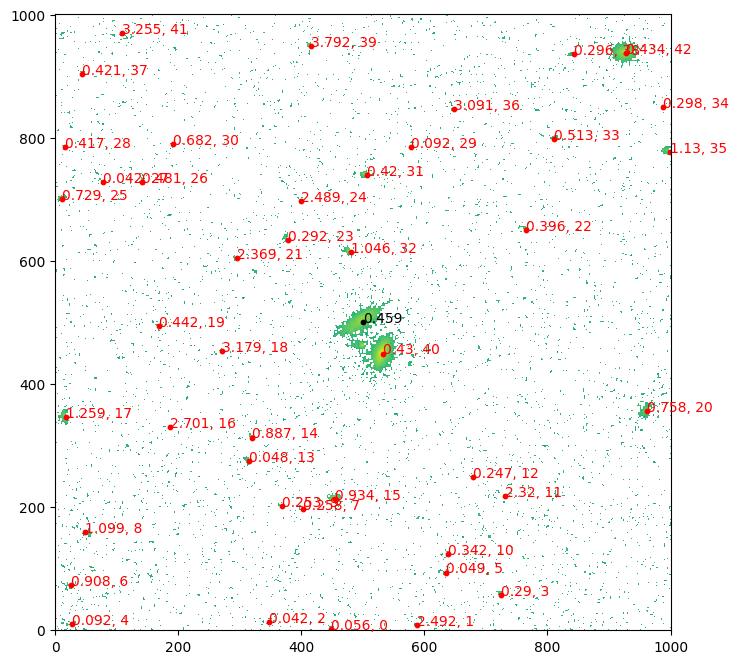

What is the correct stage? stage2


In [25]:
for counter, sourceid in enumerate(list(df_nans.SourceID)):
    
    if sourceid in list(stages_dict.keys()):
        continue
    
    ra = df_nans.query('SourceID == @sourceid')['ALPHA_J2000'].iloc[0]
    dec = df_nans.query('SourceID == @sourceid')['DELTA_J2000'].iloc[0]
    z_ez = df_nans.query('SourceID == @sourceid')['ez_z_phot'].iloc[0]
    z_lp = df_nans.query('SourceID == @sourceid')['lp_zBEST'].iloc[0]
    id_str = df_nans.query('SourceID == @sourceid')['ID'].iloc[0]
    
    redshift = picking_z(z_ez, z_lp)
    if redshift > 1.5:
        secondaries[sourceid] = 'l'
        continue
    
    prim_coord = SkyCoord(ra = ra * u.deg, dec = dec * u.deg, frame = 'fk5')
    
    df_secs = getting_secondary(ra, dec, z_ez, id_str)
    
    file = f'{fits_folder}/{sourceid}.fits'
    
    with fits.open(file) as hdul:
        im_data = hdul[0].data
        header = hdul[0].header
    
    w = WCS(header)
        
    df_coords = (
        df_secs
        .assign(coords = df_secs.apply(lambda row: SkyCoord(ra = row.ALPHA_J2000 * u.deg, dec = row.DELTA_J2000 * u.deg, frame = 'fk5'), axis = 1))
    )
    
    id_list = list(df_coords.ID)
    coords_list = list(df_coords.coords)
    z_list = list(df_coords.redshift)
    
    pixs_list = []
    for j in coords_list:
        pixs_list.append(skycoord_to_pixel(j, w, origin = 0))
    pixs_arr = np.array(pixs_list)
    
    prim_pix = np.array(skycoord_to_pixel(prim_coord, w, origin = 0))
    
    fig, ax = plt.subplots(figsize = (8,8))
    ax.imshow(np.log10(im_data), origin = 'lower')
    ax.scatter(prim_pix[0], prim_pix[1], s = 10, color='black')
    ax.annotate(np.round(redshift, 3), (prim_pix[0], prim_pix[1]), color = 'black')
    ax.scatter(pixs_arr[:,0], pixs_arr[:,1], s = 10, color = 'red')
    for i, txt in enumerate(z_list):
        ax.annotate(f'{np.round(txt, 3)}, {i}', (pixs_arr[i,0], pixs_arr[i,1]), color = 'red')
    plt.show()
    
    if counter % 10 == 0:
        print(np.round(counter / len(df_nans), 2))
    
    stage = input('What is the correct stage?')
    
    stages_dict[sourceid] = {'stage' : stage}
    
    clear_output(wait = True)

In [26]:
stages_dict

{4000705532455: {'stage': 'stage3'},
 4000812865169: {'stage': 'stage1'},
 4000840427427: {'stage': 'stage3'},
 4000859550723: {'stage': 'stage3'},
 4000859744104: {'stage': 'stage4'},
 4001044886373: {'stage': 'stage1'},
 4001060561109: {'stage': 'stage4'},
 4001066656634: {'stage': 'stage2'},
 4001072664936: {'stage': 'stage4'},
 4001074024589: {'stage': 'stage1'},
 4001093721952: {'stage': 'stage4'},
 4001096299999: {'stage': 'stage1'},
 4001120873807: {'stage': 'stage1'},
 4001120874195: {'stage': 'stage2'},
 4001124435604: {'stage': 'stage1'},
 4001144288841: {'stage': 'stage3'},
 4001162941214: {'stage': 'stage2'},
 4001162942169: {'stage': 'stage3'},
 4001169364057: {'stage': 'stage1'},
 4001169560497: {'stage': 'stage4'},
 4001199187577: {'stage': 'stage4'},
 4001202375869: {'stage': 'stage4'},
 4001202522979: {'stage': 'stage3'},
 4001204758297: {'stage': 'stage1'},
 4001212622923: {'stage': 'stage1'},
 4001234056393: {'stage': 'stage2'},
 4001241390557: {'stage': 'stage4'},
 

In [35]:
stages_df = (
    pd.DataFrame.from_dict(
        stages_dict, 
        orient = 'index'
    )
    .reset_index()
    .rename(columns = {'index' : 'SourceID', 'stage':'category'})
    .set_index('SourceID')
)

In [36]:
stages_df

,category
SourceID,
4000705532455,stage3
4000812865169,stage1
4000840427093,stage1
4000840427427,stage3
4000859550723,stage3
4000859744104,stage4
4001023244816,stage1
4001044886373,stage1
4001060561109,stage4


In [33]:
df

,SourceID,ID,category,ALPHA_J2000,DELTA_J2000,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,...,ez_ssfr_p025,ez_ssfr_p160,ez_ssfr_p500,ez_ssfr_p840,ez_ssfr_p975,ez_Av_p025,ez_Av_p160,ez_Av_p500,ez_Av_p840,ez_Av_p975
0,4000705532455,816891,NaN,150.679846,2.196543,9200.399414,21737.232422,0.000052,0.000059,-1.043282e-05,...,-8.931825,-8.911355,-8.899668,-8.883307,-8.872990,0.529107,0.560142,0.599624,0.630920,0.652330
1,4000705533383,861738,stage1,150.645118,2.237538,10033.689453,22720.843750,0.000039,0.000078,1.332813e-05,...,-9.574272,-9.548649,-9.503962,-9.439343,-9.384205,0.240042,0.281559,0.330791,0.384371,0.436491
2,4000705539529,1284864,stage1,149.686223,2.637412,33027.406250,32317.517578,0.000031,0.000030,1.244353e-06,...,-9.669377,-9.614943,-9.570104,-9.533121,-9.476167,0.094187,0.114436,0.140990,0.159430,0.183608
3,4000705539941,1301188,stage2,149.702462,2.654895,32637.949219,32737.013672,0.000064,0.000104,-2.881107e-06,...,-9.794128,-9.784252,-9.766013,-9.743796,-9.727879,0.018737,0.018737,0.018737,0.018737,0.018737
4,4000705540034,1304538,stage1,149.726828,2.658172,32053.712891,32815.468750,0.000071,0.000086,-6.036952e-06,...,-9.480532,-9.443615,-9.402433,-9.352081,-9.325659,0.302629,0.376027,0.440394,0.508153,0.567727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3791,6000535066150,1157587,stage4,150.422510,2.514655,15373.875977,29370.304688,0.000024,0.000027,8.697323e-06,...,-13.220035,-13.215519,-10.469687,-9.954029,-9.691111,0.173505,0.240862,0.328586,0.439079,0.546386
3792,6000535121452,1035987,stage1,149.694761,2.397231,32824.328125,26552.759766,0.000012,0.000015,-7.174042e-07,...,-10.287872,-10.060802,-9.853634,-9.456022,-9.315375,0.343488,0.463897,0.646257,1.016819,1.285051
3793,6000535865556,1138628,stage1,150.490889,2.496660,13734.171875,28938.828125,0.001929,0.001333,1.953999e-04,...,-9.875473,-9.817194,-9.580817,-9.265499,-9.099182,0.026873,0.026873,0.164250,0.549086,0.751945
3794,6000536013605,1203157,stage1,150.202813,2.558504,20641.730469,30421.910156,0.000051,0.000067,4.840965e-07,...,-9.804204,-9.683063,-9.470870,-9.189605,-8.982660,0.539500,0.595082,0.778112,1.062422,1.232495


In [34]:
df_int = df.set_index('SourceID')

In [37]:
df_int.update(stages_df, overwrite = False)

In [46]:
df_cat = df_int.reset_index().rename(columns = {'SourceID' : 'ORyan23_ID'})

In [47]:
df_cat

,ORyan23_ID,ID,category,ALPHA_J2000,DELTA_J2000,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,...,ez_ssfr_p025,ez_ssfr_p160,ez_ssfr_p500,ez_ssfr_p840,ez_ssfr_p975,ez_Av_p025,ez_Av_p160,ez_Av_p500,ez_Av_p840,ez_Av_p975
0,4000705532455,816891,stage3,150.679846,2.196543,9200.399414,21737.232422,0.000052,0.000059,-1.043282e-05,...,-8.931825,-8.911355,-8.899668,-8.883307,-8.87299,0.529107,0.560142,0.599624,0.63092,0.65233
1,4000705533383,861738,stage1,150.645118,2.237538,10033.689453,22720.843750,0.000039,0.000078,1.332813e-05,...,-9.574272,-9.548649,-9.503962,-9.439343,-9.384205,0.240042,0.281559,0.330791,0.384371,0.436491
2,4000705539529,1284864,stage1,149.686223,2.637412,33027.406250,32317.517578,0.000031,0.000030,1.244353e-06,...,-9.669377,-9.614943,-9.570104,-9.533121,-9.476167,0.094187,0.114436,0.14099,0.15943,0.183608
3,4000705539941,1301188,stage2,149.702462,2.654895,32637.949219,32737.013672,0.000064,0.000104,-2.881107e-06,...,-9.794128,-9.784252,-9.766013,-9.743796,-9.727879,0.018737,0.018737,0.018737,0.018737,0.018737
4,4000705540034,1304538,stage1,149.726828,2.658172,32053.712891,32815.468750,0.000071,0.000086,-6.036952e-06,...,-9.480532,-9.443615,-9.402433,-9.352081,-9.325659,0.302629,0.376027,0.440394,0.508153,0.567727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3791,6000535066150,1157587,stage4,150.422510,2.514655,15373.875977,29370.304688,0.000024,0.000027,8.697323e-06,...,-13.220035,-13.215519,-10.469687,-9.954029,-9.691111,0.173505,0.240862,0.328586,0.439079,0.546386
3792,6000535121452,1035987,stage1,149.694761,2.397231,32824.328125,26552.759766,0.000012,0.000015,-7.174042e-07,...,-10.287872,-10.060802,-9.853634,-9.456022,-9.315375,0.343488,0.463897,0.646257,1.016819,1.285051
3793,6000535865556,1138628,stage1,150.490889,2.496660,13734.171875,28938.828125,0.001929,0.001333,1.953999e-04,...,-9.875473,-9.817194,-9.580817,-9.265499,-9.099182,0.026873,0.026873,0.16425,0.549086,0.751945
3794,6000536013605,1203157,stage1,150.202813,2.558504,20641.730469,30421.910156,0.000051,0.000067,4.840965e-07,...,-9.804204,-9.683063,-9.47087,-9.189605,-8.98266,0.5395,0.595082,0.778112,1.062422,1.232495


In [49]:
df_cat.to_csv(f'{combine_fold}/cosmos2020-categorised-interactions.csv')